In [1]:
# Import helper library
import pandas as  pd 
import gc
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import train_test_split,KFold
import xgboost as xgb


# Data understanding

##  1-Understand the Task  


During this workshop we will use data from ["Traffic Jam: Predicting People's Movement into Nairobi" ](https://zindi.africa/competitions/traffic-jam-predicting-peoples-movement-into-nairobi)which is a competition powered by Uber and MobiTicket Kenya and hosted by Zindi.

## 2-Load and Transform the raw data

### 2.1 Load  data

In [2]:
train_url="https://raw.githubusercontent.com/JedidiMohamed/Workshop_Eniso/master/data/train.csv"
test_url="https://raw.githubusercontent.com/JedidiMohamed/Workshop_Eniso/master/data/test.csv"
test_target_url="https://raw.githubusercontent.com/JedidiMohamed/Workshop_Eniso/master/data/test_target.csv"
train=pd.read_csv("./train.csv")
test=pd.read_csv("./test.csv")
test_target=pd.read_csv("./test_target.csv")

In [3]:
train.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [4]:
test.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,247,2018-05-07,07:06,Kisii,Nairobi,Bus,49
1,256,2018-05-06,11:08,Kisii,Nairobi,shuttle,11
2,275,2018-05-04,05:00,Kisii,Nairobi,shuttle,11
3,285,2018-05-04,09:10,Kisii,Nairobi,shuttle,11
4,286,2018-05-04,09:20,Kisii,Nairobi,shuttle,11


In [5]:
test_target.head()

,ride_id,number_of_ticket
0,247,1
1,256,1
2,275,3
3,285,6
4,286,1


### 2.2 Transform data

The first step to solve of this problem is to create the train set. Since the data provides
information about ticket transactions, we need to group it by ride_id to to find the right number of
tickets per ride.

In [6]:
# Group train data by ride Id  and count the number of seats
Target=train.groupby(["ride_id"]).seat_number.count().rename("number_of_ticket").reset_index()
# Get Statisical features for each ride id  and  drop 'payment_method', 'payment_receipt', 'seat_number' columns 
train_df=train.drop_duplicates("ride_id").drop(['payment_method', 'payment_receipt', 'seat_number'],axis=1)
# merge  each ride with target and stastical features 
train_df=train_df.merge(Target,how="left",on="ride_id")
# drop travel to columns from train set and test set 
train_df.drop(["travel_to"],axis=1,inplace=True)
test.drop(["travel_to"],axis=1,inplace=True)

In [7]:
# processing the date columns and add Time features
def add_20(x):
    date=x.split("-")
    date[-1]="20"+date[-1]
    return "-".join(date)
train_df["date"]=(train_df["travel_date"].apply(add_20)+" "+train_df["travel_time"]).astype(str)
test["date"]=(test["travel_date"]+" "+test["travel_time"]).astype(str)

def  time_features(x): 
    x["date"]=pd.to_datetime(x["date"],format='%d-%m-%Y %H:%M')
    x["dayofweek"]=x["date"].dt.dayofweek
    x["dayofyear"]=
    x["dayofmonth"]=
    x["year_woy"]=x["date"].dt.year.astype(str)+x["date"].dt.weekofyear.astype(str)
    x["hour"]=
    x["minute"]=
    x["is_weekend"]=x["dayofweek"].apply( lambda x : 1 if x  in [5,6] else 0 )
    x["year"]
    x["quarter"]=
    x["month"]=
    

    return x 
train_df=time_features(train_df)
def  time_features(x): 
    x["date"]=pd.to_datetime(x["date"],format='%Y-%m-%d %H:%M')
    x["dayofweek"]=
    x["hour"]=
    x["minute"]=
    x["dayofyear"]=
    x["dayofmonth"]=
    x["is_weekend"]=
    x["year_woy"]=
    x["year"]=
    x["quarter"]=
    x["month"]=
    return x 
test=time_features(test)

In [8]:
train_df.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_ticket,date,dayofweek,dayofyear,dayofmonth,year_woy,hour,minute,is_weekend,year,quarter,month
0,1442,17-10-17,7:15,Migori,Bus,49,1,2017-10-17 07:15:00,1,290,17,201742,7,15,0,2017,4,10
1,5437,19-11-17,7:12,Migori,Bus,49,1,2017-11-19 07:12:00,6,323,19,201746,7,12,1,2017,4,11
2,5710,26-11-17,7:05,Keroka,Bus,49,1,2017-11-26 07:05:00,6,330,26,201747,7,5,1,2017,4,11
3,5777,27-11-17,7:10,Homa Bay,Bus,49,5,2017-11-27 07:10:00,0,331,27,201748,7,10,0,2017,4,11
4,5778,27-11-17,7:12,Migori,Bus,49,31,2017-11-27 07:12:00,0,331,27,201748,7,12,0,2017,4,11


In [9]:
test.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,date,dayofweek,hour,minute,dayofyear,dayofmonth,is_weekend,year_woy,year,quarter,month
0,247,2018-05-07,07:06,Kisii,Bus,49,2018-05-07 07:06:00,0,7,6,127,7,0,201819,2018,2,5
1,256,2018-05-06,11:08,Kisii,shuttle,11,2018-05-06 11:08:00,6,11,8,126,6,1,201818,2018,2,5
2,275,2018-05-04,05:00,Kisii,shuttle,11,2018-05-04 05:00:00,4,5,0,124,4,0,201818,2018,2,5
3,285,2018-05-04,09:10,Kisii,shuttle,11,2018-05-04 09:10:00,4,9,10,124,4,0,201818,2018,2,5
4,286,2018-05-04,09:20,Kisii,shuttle,11,2018-05-04 09:20:00,4,9,20,124,4,0,201818,2018,2,5


## 3- Data Visualization

In [10]:
# print the min and max date in the train  set 
print(train_df.date.dt.date.min(),)

# print the min and max date in the test set 
print()


2017-10-17 2018-04-20
2018-04-21 05:00:00 2018-05-09 08:00:00


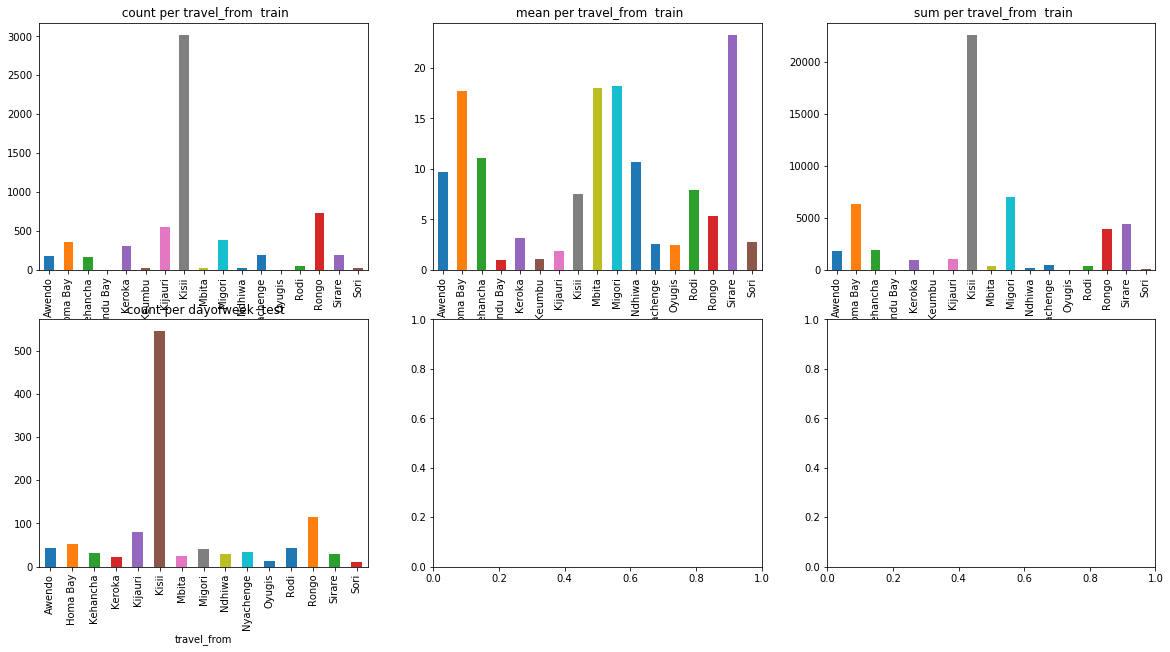

In [11]:
# plot for the train  and test , the count of ride by travel from ,  
# plot for the train the sum and mean of number_of_ticket by  travel from
fig,axs=plt.subplots(ncols=3,nrows=2)
train_df.groupby(["travel_from"]).ride_id.count().plot(kind="bar",title=" count per travel_from  train",ax=axs[0,0],figsize=(20,10))
train_df.groupby(["travel_from"]).number_of_ticket.mean().plot(kind="bar",title=" mean per travel_from  train",ax=axs[0,1],figsize=(20,10))
train_df.groupby(["travel_from"]).number_of_ticket.sum().plot(kind="bar",title=" sum per travel_from  train",ax=axs[0,2],figsize=(20,10))
test.groupby(["travel_from"]).ride_id.count().plot(kind="bar",title=" count per dayofweek  test",ax=axs[1,0],figsize=(20,10))

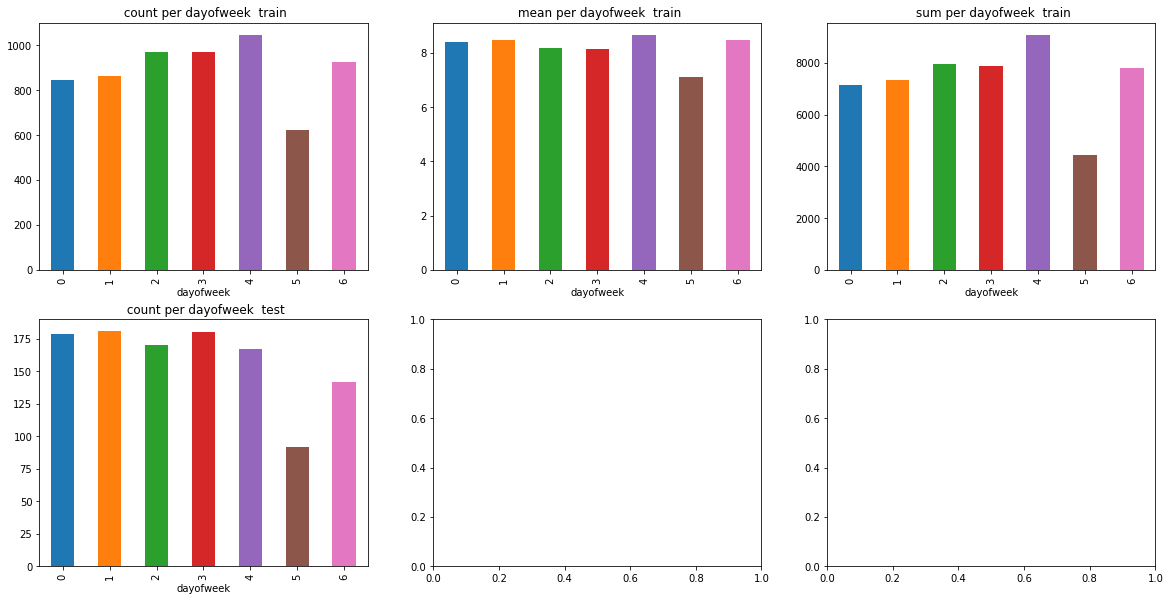

In [12]:
# plot for the train  and test , the count of ride by dayofweek ,  
# plot for the train the sum and mean of number_of_ticket by  travel from


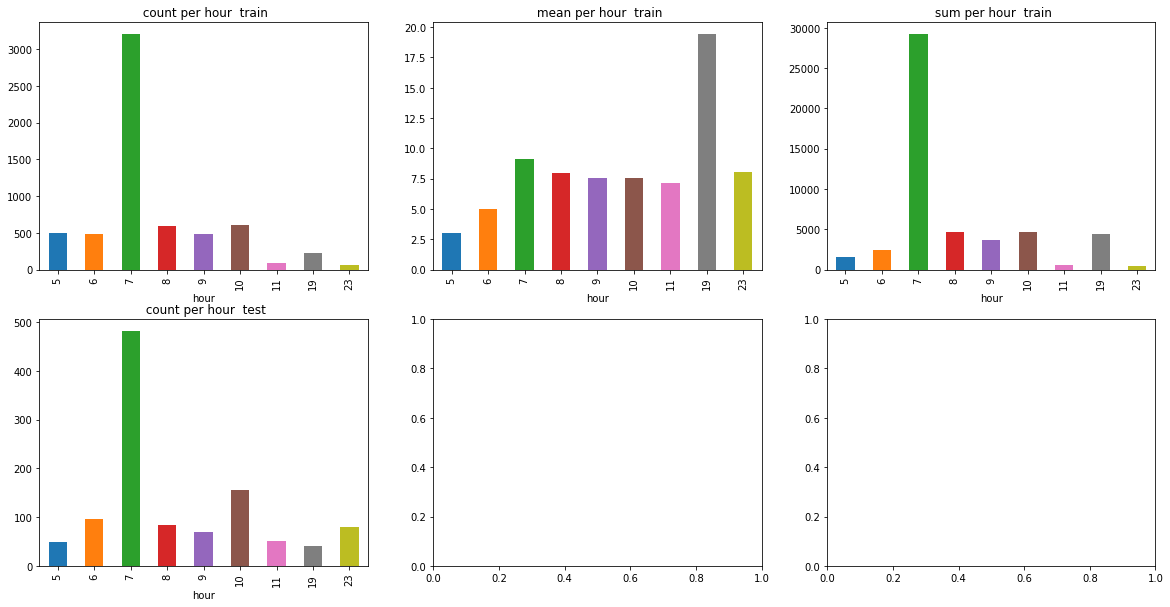

In [13]:
# plot for the train  and test , the count of ride by hour ,  
# plot for the train the sum and mean of number_of_ticket by  hour


# Data processing

## 1-Target Encoding

When you’re doing supervised learning you often have to deal with categorical variables. That is, variables which don’t have a natural numerical representation. The problem is that most machine learning algorithms require the input data to be numerical. At some point or another a data science pipeline will require converting categorical variables to numerical variables.
There many way to do so :

Label Encoding where you represent each category with random number.
One-hot encoding where you create one binary column per category
Target encoding where you where you calculate some statistical measure like (mean,max,min ...) of target value by category

Let's define a function which take as input data frame, name of the categorical feature , the name of the target column , statistical functions and return an aggregate data frame grouped by the categorical feature  

In [14]:
def target_encoding(data,feautre,target="number_of_ticket",agg_functions={"mean","std"}):
    agg=data.groupby(feautre)[target].agg(agg_functions)
    agg.columns=[column+"_per_{}_{}".format(feautre,target) for column in  agg.columns.tolist()]
    return agg    


In [15]:
test.columns.tolist()

['ride_id',
 'travel_date',
 'travel_time',
 'travel_from',
 'car_type',
 'max_capacity',
 'date',
 'dayofweek',
 'hour',
 'minute',
 'dayofyear',
 'dayofmonth',
 'is_weekend',
 'year_woy',
 'year',
 'quarter',
 'month']

In [1]:
# Select categorical features
categorical_features=["hour" , "travel_from" ,"minute","dayofweek"]

### 1.1 -First level interaction 

In [3]:
# calculate the aggregate data frame for each categorical features and join with the train, test set
for feature in categorical_features : 
    agg=target_encoding(train_df,feature)
    train_df=train_df.merge(agg,how="left",on=feature)
    test=test.merge(agg,how="left",on=feature)
    del agg
    gc.collect()

NameError: name 'target_encoding' is not defined

### 1.2-Second level interaction 

In [18]:
def target_encoding(data,feature,target="number_of_ticket",agg_functions={"mean"}):
    agg=data.groupby(feature)[target].agg(agg_functions)
    agg.columns=[column+"_per_{}_{}".format("_".join(feature),target) for column in  agg.columns.tolist()]
    return agg  

In [19]:
Second_level_categorical_features=[ ["hour","dayofweek"],
            ["hour","travel_from"],
            ["dayofweek","travel_from"] ,
            ["minute","travel_from"] ]



In [20]:
train_df.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,number_of_ticket,date,dayofweek,dayofyear,...,mean_per_travel_from_number_of_ticket,std_per_travel_from_number_of_ticket,mean_per_minute_number_of_ticket,std_per_minute_number_of_ticket,mean_per_dayofweek_number_of_ticket,std_per_dayofweek_number_of_ticket,mean_per_hour_dayofweek_number_of_ticket,mean_per_hour_travel_from_number_of_ticket,mean_per_dayofweek_travel_from_number_of_ticket,mean_per_minute_travel_from_number_of_ticket
0,1442,17-10-17,7:15,Migori,Bus,49,1,2017-10-17 07:15:00,1,290,...,18.204663,12.937696,12.850299,11.000344,8.475145,8.652480,8.965368,18.595376,17.714286,18.157407
1,5437,19-11-17,7:12,Migori,Bus,49,1,2017-11-19 07:12:00,6,323,...,18.204663,12.937696,22.264151,14.695411,8.462121,8.599534,9.092593,18.595376,18.346154,28.231405
2,5710,26-11-17,7:05,Keroka,Bus,49,1,2017-11-26 07:05:00,6,330,...,3.166667,3.267955,6.806338,5.850417,8.462121,8.599534,9.092593,2.271605,3.625000,2.250000
3,5777,27-11-17,7:10,Homa Bay,Bus,49,5,2017-11-27 07:10:00,0,331,...,17.707865,12.158301,5.980583,4.349472,8.409198,8.991864,9.145695,17.707865,17.018519,5.540000
4,5778,27-11-17,7:12,Migori,Bus,49,31,2017-11-27 07:12:00,0,331,...,18.204663,12.937696,22.264151,14.695411,8.409198,8.991864,9.145695,18.595376,17.314815,28.231405


In [21]:
test.head()

,ride_id,travel_date,travel_time,travel_from,car_type,max_capacity,date,dayofweek,hour,minute,...,mean_per_travel_from_number_of_ticket,std_per_travel_from_number_of_ticket,mean_per_minute_number_of_ticket,std_per_minute_number_of_ticket,mean_per_dayofweek_number_of_ticket,std_per_dayofweek_number_of_ticket,mean_per_hour_dayofweek_number_of_ticket,mean_per_hour_travel_from_number_of_ticket,mean_per_dayofweek_travel_from_number_of_ticket,mean_per_minute_travel_from_number_of_ticket
0,247,2018-05-07,07:06,Kisii,Bus,49,2018-05-07 07:06:00,0,7,6,...,7.485762,5.098253,5.943925,7.734458,8.409198,8.991864,9.145695,7.831021,7.665854,9.800000
1,256,2018-05-06,11:08,Kisii,shuttle,11,2018-05-06 11:08:00,6,11,8,...,7.485762,5.098253,9.057229,8.158904,8.462121,8.599534,8.122449,7.463415,7.641949,4.074074
2,275,2018-05-04,05:00,Kisii,shuttle,11,2018-05-04 05:00:00,4,5,0,...,7.485762,5.098253,6.945166,7.504519,8.675573,8.407693,2.876923,3.156627,7.828473,6.404206
3,285,2018-05-04,09:10,Kisii,shuttle,11,2018-05-04 09:10:00,4,9,10,...,7.485762,5.098253,5.980583,4.349472,8.675573,8.407693,8.629630,8.288018,7.828473,7.439597
4,286,2018-05-04,09:20,Kisii,shuttle,11,2018-05-04 09:20:00,4,9,20,...,7.485762,5.098253,6.716981,4.010635,8.675573,8.407693,8.629630,8.288018,7.828473,7.838235


## 2-time interval separating rides 

In [22]:
# in this step we need to concat the train and the test set 
test["train"]=0
train_df["train"]=1
data=pd.concat([test,train_df])
# sort the data with  travel from and date  
data.sort_values(["travel_from","date"],inplace=True,ascending=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [23]:
# time interval separating this ride’s bus and the next bus
data["diff_btw_0_1_next_bus"]=(data["date"]-data.groupby(["travel_from"]).date.shift(-1)).dt.total_seconds()/60/60
# time interval separating this ride’s bus and the previous bus
data["diff_btw_0_1_previous_bus"]=(data["date"]-data.groupby(["travel_from"]).date.shift(1)).dt.total_seconds()/60/60
# time interval separating this ride’s bus and the following bus to the next bus.
data["diff_btw_0_2_next_bus"]=
# time interval separating this ride’s bus and the bus before the previous bus.
data["diff_btw_0_2_previous_bus"]=
# time interval separating this ride’s bus and 3rd following it.
data["diff_btw_0_3_next_bus"]=
# time interval separating the next ride's bus and  the bus before  .
data["diff_btw_next_previous_bus"]=
# fill the nan values 
fea=['diff_btw_0_1_next_bus', 'diff_btw_0_1_previous_bus', 'diff_btw_0_2_next_bus', 'diff_btw_0_2_previous_bus',
     'diff_btw_0_3_next_bus','diff_btw_next_previous_bus']
data[fea]=data.groupby(["travel_from"])[fea].fillna(method="ffill")
data[fea]=data.groupby(["travel_from"])[fea].fillna(method="backfill")


## 3-Number of rides per X time coming to Nairobi. 

In [24]:
for time  in [1,3,5,7,10,15] : 
    data["count_trip_per_{}min".format(str(time))]=data.groupby([pd.Grouper(key="date",freq='{}min'.format(time))]).ride_id.transform("count")

## 4-Number of rides per X time coming from each city 

In [25]:
for i in [1,3,5,7,10,15] :
    data["count_trip_per_{}min_travel_from".format(str(i))]=

## 5-Distance and Trip Duration 

In [26]:
distance = {'Migori': 372 , 'Keroka': 281, 'Homa Bay':364, 'Kisii':305.1, 'Keumbu':295, 'Rongo':332,
'Kijauri':271, 'Oyugis':330.6, 'Awendo':351, 'Sirare':392, 'Nyachenge':326, 'Kehancha': 387.7,
'Kendu Bay':347, 'Sori':399, 'Rodi':348, 'Mbita':401, 'Ndhiwa': 371}
# map travel from column with distance
data["travel_from_distance"]=

In [27]:
time = {'Migori': 7*60+8 , 'Keroka': 5*60, 'Homa Bay':7*60, 'Kisii':5*60+34, 'Keumbu':5*60+20, 'Rongo':6*60+21,
'Kijauri':60*4+50,'Oyugis':5*60+50, 'Awendo':6*60+38, 'Sirare':7*60+30, 'Nyachenge':6*60+10, 'Kehancha':7*60+10,
'Kendu Bay':6*60+10, 'Sori':7*60+30, 'Rodi':6*60+40, 'Mbita':7*60+23, 'Ndhiwa': 7*60}
# map travel from column with time
data["travel_from_time"]=

In [93]:
# Split data to train_df and test
train_df=
test=

In [94]:
# reset index 
train_df.reset_index(inplace=True,drop=True)
test.

# Modeling 

In [95]:
train_df.columns

Index(['car_type', 'date', 'dayofmonth', 'dayofweek', 'dayofyear', 'hour',
       'is_weekend', 'max_capacity', 'mean_per_dayofweek_number_of_ticket',
       'mean_per_dayofweek_travel_from_number_of_ticket',
       'mean_per_hour_dayofweek_number_of_ticket',
       'mean_per_hour_number_of_ticket',
       'mean_per_hour_travel_from_number_of_ticket',
       'mean_per_minute_number_of_ticket',
       'mean_per_minute_travel_from_number_of_ticket',
       'mean_per_travel_from_number_of_ticket', 'minute', 'month',
       'number_of_ticket', 'quarter', 'ride_id',
       'std_per_dayofweek_number_of_ticket', 'std_per_hour_number_of_ticket',
       'std_per_minute_number_of_ticket',
       'std_per_travel_from_number_of_ticket', 'train', 'travel_date',
       'travel_from', 'travel_time', 'year', 'year_woy',
       'diff_btw_0_1_next_bus', 'diff_btw_0_1_previous_bus',
       'diff_btw_0_2_next_bus', 'diff_btw_0_2_previous_bus',
       'diff_btw_0_3_next_bus', 'diff_btw_next_previous_bus',


In [96]:
Col_to_drop=[ 'date', 'dayofmonth', 'dayofweek', 'dayofyear',"number_of_ticket","car_type",
            "travel_date", "travel_from", "travel_time", "year_woy","ride_id","quarter","month","year","train"]
features_name=train_df.drop(Col_to_drop,axis=1).columns.tolist()
features_name

['hour',
 'is_weekend',
 'max_capacity',
 'mean_per_dayofweek_number_of_ticket',
 'mean_per_dayofweek_travel_from_number_of_ticket',
 'mean_per_hour_dayofweek_number_of_ticket',
 'mean_per_hour_number_of_ticket',
 'mean_per_hour_travel_from_number_of_ticket',
 'mean_per_minute_number_of_ticket',
 'mean_per_minute_travel_from_number_of_ticket',
 'mean_per_travel_from_number_of_ticket',
 'minute',
 'std_per_dayofweek_number_of_ticket',
 'std_per_hour_number_of_ticket',
 'std_per_minute_number_of_ticket',
 'std_per_travel_from_number_of_ticket',
 'diff_btw_0_1_next_bus',
 'diff_btw_0_1_previous_bus',
 'diff_btw_0_2_next_bus',
 'diff_btw_0_2_previous_bus',
 'diff_btw_0_3_next_bus',
 'diff_btw_next_previous_bus',
 'count_trip_per_1min',
 'count_trip_per_3min',
 'count_trip_per_5min',
 'count_trip_per_7min',
 'count_trip_per_10min',
 'count_trip_per_15min',
 'count_trip_per_1min_travel_from',
 'count_trip_per_3min_travel_from',
 'count_trip_per_5min_travel_from',
 'count_trip_per_7min_travel

## 1-Sample Validation 

In [98]:
# Split train to Train and Val with test_size = 0.1 and random_state=5248
Train,Val=
# remove useless columns  for train set
X_train=
Y_train=
# remove useless columns  for val set
X_val=
Y_val=
# remove useless columns  for test set
X_test=
print( "Train ", X_train.shape)
print( "Val ", X_val.shape)
print( "Test ", X_test.shape)
assert X_train.shape[1]== 36
assert X_val.shape[1]== 36
assert X_test.shape[1]== 36

Train  (5624, 36)
Val  (625, 36)
Test  (1111, 36)


In [4]:
# Define function to train our data in one fold wich take train, validation, test data and return the prediction of the train, validation and test

In [100]:
def train_model(X_train,Y_train,X_val,Y_val,X_test,parmaters,features_name): 
    d_train = xgb.DMatrix(X_train, Y_train,feature_names=features_name)
    d_valid = xgb.DMatrix(X_val, Y_val,feature_names=features_name)
    d_test = xgb.DMatrix(X_test,feature_names=features_name)
    list_track = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(parmaters, d_train, 2000,  list_track, maximize=False, verbose_eval=50, early_stopping_rounds=50)
    train_pred =model.predict(d_train)              
    valid_pred =model.predict(d_valid)   
    test_pred = model.predict(d_test)
    return train_pred ,valid_pred,test_pred

In [101]:
params = {'eta': 0.004, 'colsample_bytree': 0.7, 
               'max_depth': 9,'subsample': 0.9, 'lambda': 4, 'nthread': 8, 'booster' : 'gbtree', 'silent': 1,
               'eval_metric': 'rmse', 'objective': 'reg:linear',"gamma":0.1 ,"alpha":0.01} 
# Train the data with Xgboost model using train_model funcation 
train_pred ,valid_pred,test_pred=

[0]	train-rmse:11.5944	valid-rmse:11.3898
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:9.93348	valid-rmse:9.85657
[100]	train-rmse:8.60146	valid-rmse:8.65181
[150]	train-rmse:7.53908	valid-rmse:7.71424
[200]	train-rmse:6.69684	valid-rmse:6.99404
[250]	train-rmse:6.02357	valid-rmse:6.43927
[300]	train-rmse:5.49112	valid-rmse:6.03189
[350]	train-rmse:5.06474	valid-rmse:5.7285
[400]	train-rmse:4.71988	valid-rmse:5.50828
[450]	train-rmse:4.43734	valid-rmse:5.34112
[500]	train-rmse:4.20524	valid-rmse:5.22201
[550]	train-rmse:4.01272	valid-rmse:5.1296
[600]	train-rmse:3.84983	valid-rmse:5.06214
[650]	train-rmse:3.71135	valid-rmse:5.01263
[700]	train-rmse:3.59019	valid-rmse:4.97637
[750]	train-rmse:3.48219	valid-rmse:4.94943
[800]	train-rmse:3.38521	valid-rmse:4.92805
[850]	train-rmse:3.29846	valid-rmse:4.9143
[900]	train-rmse:3.22114	valid-rmse:4.90465
[950]	train-rmse:3.14994	

In [102]:
print("Train ",mean_absolute_error.__name__ , mean_absolute_error(Y_train,train_pred))
print("Validation  ",mean_absolute_error.__name__ , mean_absolute_error(Y_val,valid_pred))

Train  mean_absolute_error 1.8984512892971677
Validation   mean_absolute_error 3.0016544120788575


## 2- Kfold Validation strategy

In [103]:
def train_kfold(X_train,Y_train,X_test,parmaters,features_name,split=5):
    final_train_pred=np.zeros_like(Y_train)
    final_test_pred=np.zeros(len(X_test))
 
    
    kf = KFold(n_splits=split,random_state=2222)
    i=1
    for train_index, val_index in kf.split(X_train):
        print("fold:"+str(i))
        train_fold_features, val_fold_features = X_train.loc[train_index], X_train.loc[val_index]
        train_fold_target, val_fold_target = Y_train.loc[train_index], Y_train.loc[val_index] 
        train_pred ,valid_pred,test_pred=train_model( 
                                                        X_train=train_fold_features,
                                                        Y_train= train_fold_target,
                                                        X_val= val_fold_features,
                                                        Y_val= val_fold_target,
                                                        X_test= X_test,
                                                        parmaters=parmaters,
                                                        features_name=features_name 
                                                    )
        
        final_train_pred[val_index]=valid_pred
        final_test_pred=final_test_pred+test_pred/split
        i=i+1
    return final_train_pred,final_test_pred


In [104]:
Train=
Y_train=
print( Train.shape)
print( Y_train.shape)
assert len(Train)==len(Y_train)
assert len(Train)==6249

(6249, 36)
(6249,)


In [105]:
# Train the data with Kfold method with K=10
train_pred_kfold,test_pred_kfold= 

fold:1
[0]	train-rmse:10.6854	valid-rmse:17.6874
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:9.17378	valid-rmse:16.2603
[100]	train-rmse:7.96434	valid-rmse:15.2902
[150]	train-rmse:6.99912	valid-rmse:14.313
[200]	train-rmse:6.23044	valid-rmse:13.4974
[250]	train-rmse:5.61822	valid-rmse:12.8371
[300]	train-rmse:5.12844	valid-rmse:12.2615
[350]	train-rmse:4.74343	valid-rmse:11.8233
[400]	train-rmse:4.43018	valid-rmse:11.4684
[450]	train-rmse:4.17228	valid-rmse:11.1862
[500]	train-rmse:3.96056	valid-rmse:10.939
[550]	train-rmse:3.78025	valid-rmse:10.751
[600]	train-rmse:3.62758	valid-rmse:10.5877
[650]	train-rmse:3.49636	valid-rmse:10.4574
[700]	train-rmse:3.38003	valid-rmse:10.3355
[750]	train-rmse:3.27686	valid-rmse:10.2435
[800]	train-rmse:3.18787	valid-rmse:10.161
[850]	train-rmse:3.10868	valid-rmse:10.0859
[900]	train-rmse:3.0348	valid-rmse:10.0187
[950]	train-rmse:2.9

In [106]:
print("CV  ",mean_absolute_error.__name__ , mean_absolute_error(Y_train,train_pred_kfold))

Validation   mean_absolute_error 3.8231421079916426


# Evaluation

In [109]:
def evaluation(pred,test,test_target,validation_type=""):
    test["predection_target"]=pred
    test_target=test_target.merge(test[["ride_id","predection_target"]],on="ride_id",how="left")
    print( validation_type+" ",mean_absolute_error.__name__ , mean_absolute_error(test_target.number_of_ticket,test_target.predection_target))

In [110]:
evaluation(test_pred,test,test_target,"Simple validation")
evaluation(test_pred_kfold,test,test_target,"Kfold")

Simple validation  mean_absolute_error 3.6174486679176723
Kfold  mean_absolute_error 3.599984739723504


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
